# OS-MNIST Visualization

## 1. Generate Data

In [115]:
import os
os.system("python3 build_os-mnist.py --testrun")
#os.system("python3 build_os-mnist.py --testrun --fashion")
#os.system("python3 build_os-mnist.py --testrun --kuzushiji")

0

## 2. Load Data

load standard libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

get tf-record parser

In [20]:
def _multimnist_parse_osmnist(example_proto):
    features = {
        "image_left": tf.FixedLenFeature([], tf.string),
        "image_right": tf.FixedLenFeature([], tf.string),
        "label1": tf.FixedLenFeature([], tf.int64),
        "label2": tf.FixedLenFeature([], tf.int64),
        "label3": tf.FixedLenFeature([], tf.int64),
        "occlusion_left": tf.FixedLenFeature([], tf.float32),
        "occlusion_right": tf.FixedLenFeature([], tf.float32),
        "occlusion_avg": tf.FixedLenFeature([], tf.float32),
        "segmap_left": tf.FixedLenFeature([], tf.string),
        "segmap_right": tf.FixedLenFeature([], tf.string),
      }
        

    parsed_features = tf.parse_single_example(example_proto, features)
    
    no_classes = 10
    one_hot = tf.one_hot(parsed_features["label1"], no_classes)
    
    occ1_one_hot = tf.one_hot(parsed_features["label2"], no_classes)
    occ2_one_hot = tf.one_hot(parsed_features["label3"], no_classes)
    n_hot = one_hot + occ1_one_hot + occ2_one_hot

    images_encoded_l =  parsed_features["image_left"]
    images_encoded_r =  parsed_features["image_right"]

    image_decoded_l = tf.image.decode_png(images_encoded_l)
    image_decoded_r = tf.image.decode_png(images_encoded_r)
    
    segmaps_encoded_l =  parsed_features["segmap_left"]
    segmaps_encoded_r =  parsed_features["segmap_right"]

    segmap_decoded_l = tf.image.decode_png(segmaps_encoded_l)
    segmap_decoded_r = tf.image.decode_png(segmaps_encoded_r)

    return image_decoded_l, image_decoded_r, segmap_decoded_l,\
        segmap_decoded_r, n_hot, one_hot, parsed_features["occlusion_left"], parsed_features["occlusion_avg"]


use parser to get to data

In [26]:
ds = tf.data.TFRecordDataset('tfrecord_files/2occ/test/osmnist_test1.tfrecord')
#ds = tf.data.TFRecordDataset('osfashionmnist/tfrecord_files/2occ/test/osfashionmnist_test0.tfrecord')
#ds = tf.data.TFRecordDataset('oskuzushijimnist/tfrecord_files/2occ/test/oskuzushijimnist_test0.tfrecord')


ds = ds.map(_multimnist_parse_osmnist)
ds = ds.batch(100, drop_remainder=True)
iterator = ds.make_initializable_iterator()

In [27]:
sess = tf.Session()
sess.run(iterator.initializer)

## 3. Visualize Data

loop through data and use matplotlib to show its contents

In [28]:
next_step = iterator.get_next()
print(len(next_step))

8


In [29]:
batch = sess.run(iterator.get_next())

In [30]:
left_im = batch[0][0, :, :, 0]
right_im = batch[1][0, :, :, 0]
left_segmap = batch[2][0]
left_bin_segmap = batch[2][0, :, :, 0]
left_bin_segmap = left_bin_segmap > 0
left_bin_segmap = np.asarray(left_bin_segmap, dtype=int)
right_segmap = batch[3][0]
right_bin_segmap = batch[3][0, :, :, 0]
right_bin_segmap = right_bin_segmap > 0
right_bin_segmap = np.asarray(right_bin_segmap, dtype=int)
occlusion_left = batch[-2]
occlusion_avg = batch[-1]

In [31]:
batch[2].shape

(100, 32, 32, 3)

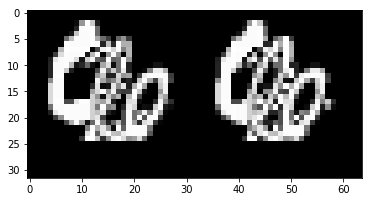

In [32]:
plt.imshow(np.concatenate([left_im, right_im], axis=1), cmap='gray')

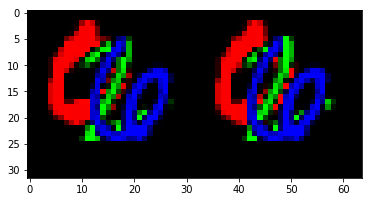

In [33]:
plt.imshow(np.concatenate([left_segmap, right_segmap], axis=1))

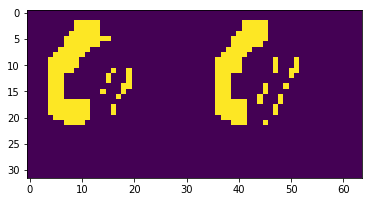

In [34]:
plt.imshow(np.concatenate([left_bin_segmap, right_bin_segmap], axis=1))

avg occlusion: [0.38601035 0.3106509  0.6339286  0.2947761  0.37244898 0.45454547
 0.2601156  0.41162792 0.328125   0.63414633 0.49333334 0.6617647
 0.72131145 0.5740741  0.36       0.6195652  0.63461536 0.575
 0.54022986 0.6666667  0.6891892  0.6351351  0.7151515  0.5027933
 0.59375    0.65841585 0.4516129  0.28443113 0.4448819  0.51358694
 0.5452381  0.4742647  0.3807947  0.59565216 0.5776699  0.6021898
 0.69005847 0.45416668 0.5889571  0.3535032  0.53125    0.37083334
 0.56296295 0.5943396  0.6923077  0.6626984  0.32407406 0.47727272
 0.6        0.33211678 0.5833333  0.625      0.3275862  0.26030928
 0.7199074  0.5833333  0.40875912 0.42222223 0.61567163 0.73376626
 0.328125   0.6927083  0.5988372  0.6961538  0.5321429  0.352
 0.38071066 0.6533333  0.34768212 0.5674847  0.5833333  0.62068963
 0.29439253 0.516      0.71276593 0.4054054  0.46183205 0.7614679
 0.43951613 0.39304814 0.507874   0.5615942  0.57923496 0.46875
 0.6037736  0.4172662  0.65254235 0.4125683  0.48369566 0.400793

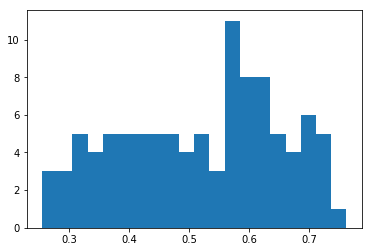

In [35]:
print('avg occlusion: {}'.format(occlusion_avg))
plt.hist(occlusion_avg, bins=20)
plt.show()

In [36]:
# plt.imshow(left_im - right_im)

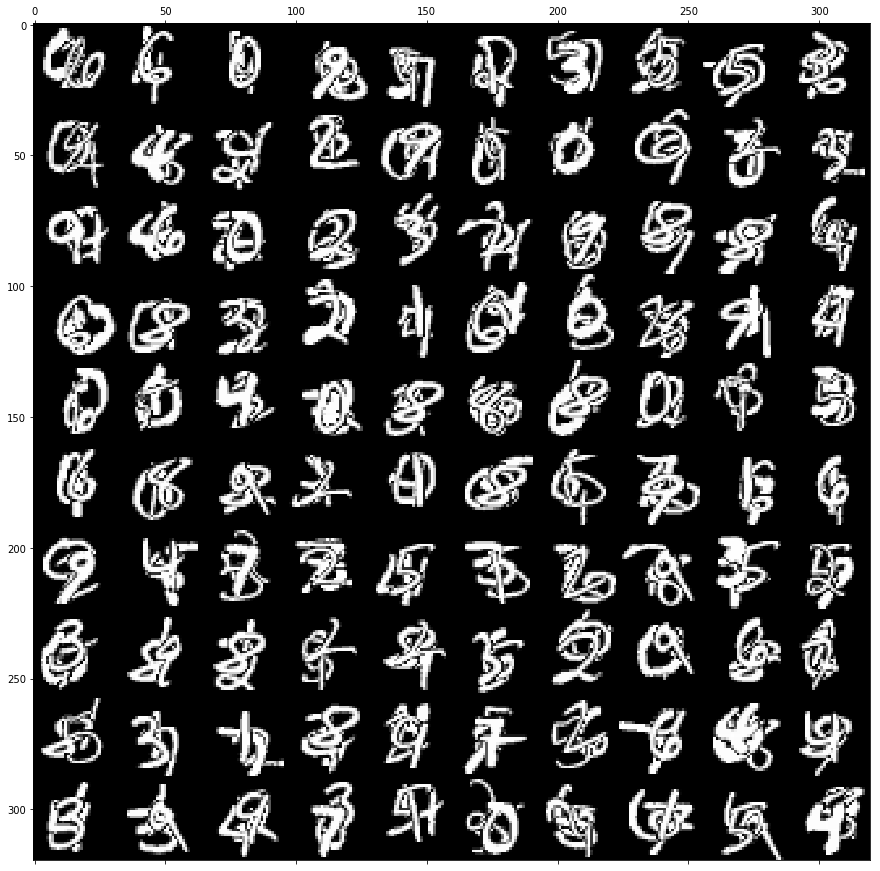

In [37]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 15]
plt.matshow(np.concatenate(
    [np.reshape(batch[0][0:10], [320,32]),
     np.reshape(batch[0][10:20], [320,32]),
     np.reshape(batch[0][20:30], [320,32]),
     np.reshape(batch[0][30:40], [320,32]),
     np.reshape(batch[0][40:50], [320,32]),
     np.reshape(batch[0][50:60], [320,32]),
     np.reshape(batch[0][60:70], [320,32]),
     np.reshape(batch[0][70:80], [320,32]),
     np.reshape(batch[0][80:90], [320,32]),
     np.reshape(batch[0][90:100], [320,32])
    ], axis=1), cmap='gray')
mpl.rcParams['figure.figsize'] = [6, 6]

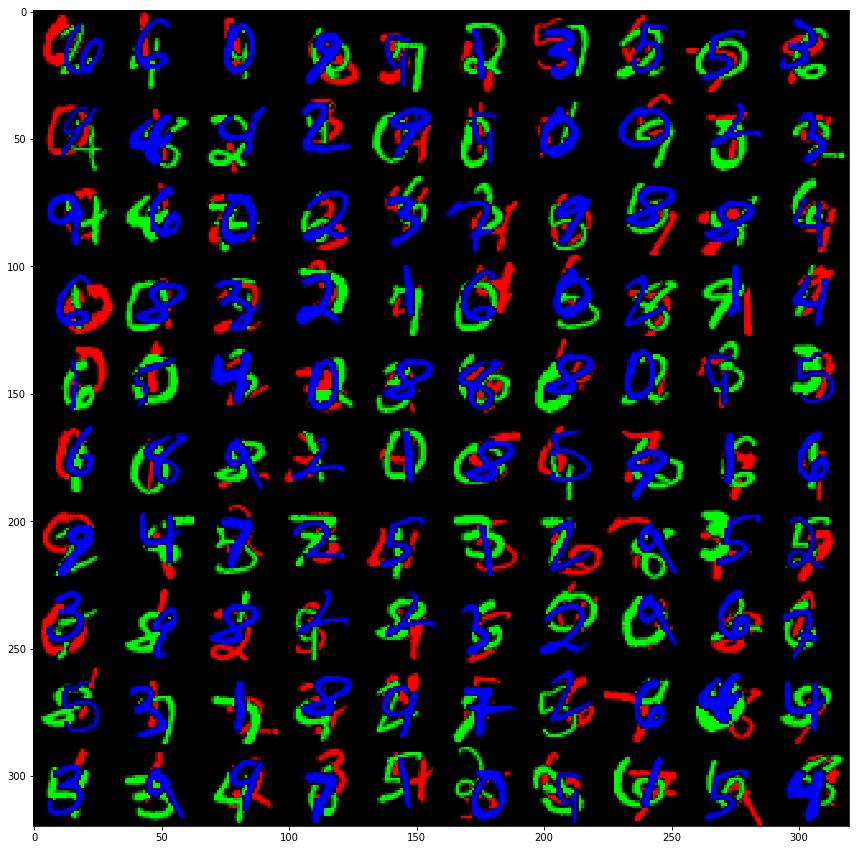

In [38]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 15]
plt.imshow(np.concatenate(
    [np.reshape(batch[2][0:10], [320,32,3]),
     np.reshape(batch[2][10:20], [320,32,3]),
     np.reshape(batch[2][20:30], [320,32,3]),
     np.reshape(batch[2][30:40], [320,32,3]),
     np.reshape(batch[2][40:50], [320,32,3]),
     np.reshape(batch[2][50:60], [320,32,3]),
     np.reshape(batch[2][60:70], [320,32,3]),
     np.reshape(batch[2][70:80], [320,32,3]),
     np.reshape(batch[2][80:90], [320,32,3]),
     np.reshape(batch[2][90:100], [320,32,3])
    ], axis=1))
mpl.rcParams['figure.figsize'] = [6, 6]